In [55]:
#import os
import sqlite3
from datetime import datetime
import warnings
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#from matplotlib.colors import LinearSegmentedColormap
#from matplotlib import colors as mcolors
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster import hierarchy



# Suppression warnings KMeans
warnings.filterwarnings(action='ignore', 
                        message='KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.')
warnings.filterwarnings(action='ignore', 
                        message='KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.')


# Liste des fonctions

def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)
        
def f_clusters_transform (df):
    """
    df : dataframe pandas
    """
    data = df.values.T
    names = df.columns
    return(data, names)



def f_clusters_coude (df, k_fine:int=15, k_seuil:int=15, k_end:int=50, n_init:int=10) :
    """
    df : dataframe à entrer
    k_fine : dernier point à calculer avec n_init
    k_seuil : point à partir duquel est calculé k_opt (premier point à tracer avec k=1)
    k_end : dernier point à calculer. De k_fine+1 à k_end, n_init=n_init//2      
    """   
    data, names = f_clusters_transform(df)
    
    if k_fine >= data.shape[0] // 2 :
        k_fine = data.shape[0] // 2

    if k_end > data.shape[0]:
        k_end = data.shape[0]

    results = pd.DataFrame(columns=["Sum_of_squared_distances"], index=np.arange(1,k_end+1))

    K = np.arange(1,k_fine+1)
    for k in tqdm (K,  
               desc="Calcul de l'inertie",  
               ascii=False, ncols=100) : 
        km = KMeans(n_clusters=k, n_init=n_init) 
        km = km.fit(data) 
        results.loc[k,"Sum_of_squared_distances"] = km.inertia_

    K_seuil = np.arange(k_fine, k_end+1)
    for k in tqdm (K_seuil,  
               desc="Calcul du seuil…",  
               ascii=False, ncols=100) : 
        km = KMeans(n_clusters=k, n_init=n_init//2) 
        km = km.fit(data) 
        results.loc[k,"Sum_of_squared_distances"] = km.inertia_

    results["score_smooth"] = results["Sum_of_squared_distances"].rolling(window =  5,
                                                                min_periods = 3,
                                                                center = True).mean()
        
    # Normalisation de Sum_of_squared_distances entre 1 et k_fine pour avoir un graph orthonormé
    scaler = MinMaxScaler(feature_range=(0,k_end-1))
    results["score_norm"] = scaler.fit_transform(results["Sum_of_squared_distances"].values.reshape(-1,1))

    
    
    # Liste vide pour les valeurs k_opt pour chaque calcul entre k_fine et k_fine+1
    k_opt_list=[]

    fig = plt.figure(figsize=(16, 7))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # Calcul des paramètres des droites et des distances à la perpendiculaire
    for k in range(k_seuil, k_end+1) :

        a = (results.loc[k,"score_norm"] - results.loc[1,"score_norm"]) / (k-1)
        b = results.loc[1,"score_norm"] - a

        distance = []
        for point in range(2,k):
            p_a = -1 / a
            p_b = results.loc[point,"score_norm"]-point*p_a
            x_intersec = (p_b-b)/(a-p_a)
            distance.append(np.sqrt((x_intersec-point)**2 + (a*x_intersec+b - results.loc[point,"score_norm"])**2))
        distance = np.array(distance) 
        k_opt = np.where(distance == distance.max())[0][0]+2

        p_b_max = results.loc[k_opt,"score_norm"]-k_opt*p_a
        x_intersec = (p_b_max-b)/(a-p_a)
        y_intersec = p_a*x_intersec + p_b_max

        k_opt_list.append(k_opt)
        
        # Affichage d'une ligne sur 2
        if k%2 == 0:
            ax1.plot([1,k], [a*1+b , a*k+b])
            ax1.plot([k_opt, x_intersec], [results.loc[k_opt,"score_norm"], y_intersec] )

    sns.countplot(x= k_opt_list)    
    k_opt = pd.Series(k_opt_list).value_counts().index[0]

    ax1.plot(results.score_norm)
    ax1.scatter(k_opt, results.loc[k_opt,"score_norm"],s=100, c='red', marker='X')    
    ax1.axvline(x=k_opt, ymax = results.loc[k_opt,"score_norm"]/results.loc[1,"score_norm"] , color='gray',linestyle='--')
    _=fig.suptitle(f"Nombre de cluster optimal : {k_opt}")  
 
    return k_opt, results
    
    
def f_clusters_fit (df, k:int = 4, n_init:int = 100, max_iter:int = 2000):
    
    """
    Entrainement et affichage de la distribution dans les clusters
    return :
    - cluster_table : df bss - cluster - MSE
    - df_clusters_centers : df série temporelle des clusters
    - metric : "euclidean" / "dtw" / "softdtw"
    """
    
    data, names = f_clusters_transform(df)
    # Initilialisation du modèle
    km = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, random_state=2022)
    # Entraînement du modèle
    km.fit(data)
    # Définition des numéros de cluster
    labels = km.labels_+1 
    # Profils des clusters
    cluster_centers = np.array(km.cluster_centers_)
    df_cluster_centers = pd.DataFrame(cluster_centers.T, index=df.index)
    for cluster in range(df_cluster_centers.shape[1]):
        df_cluster_centers.rename(columns = {cluster:f"cluster_{cluster+1}"}, inplace=True)
    
    # Création du dataframe de résultats
    cluster_table = pd.DataFrame()
    cluster_table["code_bss"] = names
    cluster_table.set_index("code_bss", inplace=True)
    cluster_table["cluster"] = labels
    for piezo in cluster_table.index :
        cluster_table.loc[piezo, "MSE"] = mean_squared_error(df.loc[:,piezo], cluster_centers[cluster_table.loc[piezo, "cluster"]-1])
    
    return cluster_table, df_cluster_centers

def f_plot_clusters (df, cluster_table, cluster_centers, plot_mean:bool = True):
    
    data, names = f_clusters_transform (df)
    
    labels = cluster_table["cluster"]
    
    fig, axs = plt.subplots(len(set(labels)),1,figsize=(20,4*cluster_centers.shape[1]))
    row_i=0

    for label in set(labels):
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i].plot(df.iloc[:,i],alpha=0.4)
        if plot_mean:
            axs[row_i].plot(cluster_centers.iloc[:,label-1],c="red")
        axs[row_i].set_title("Cluster "+str(row_i+1))
        row_i+=1
    plt.show()
    
def f_plot_all (df, cluster_table, df_cluster_centers) :

    if df.shape[1]%4 == 0:
        nbre_lignes = df.shape[1]//4
    else : 
        nbre_lignes = df.shape[1]//4 + 1

    fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
    #fig.suptitle('Series')
    for i in range(nbre_lignes):
        for j in range(4):
            if i*4+j+1>df.shape[1]: # pass the others that we can't fill
                continue
            axs[i, j].plot(df.iloc[:,i*4+j])
            axs[i, j].plot(df_cluster_centers.iloc[:,cluster_table.iloc[i*4+j,0]-1])
            
            axs[i, j].set_title(df.columns[i*4+j] + f" - MSE = {round(cluster_table.loc[df.columns[i*4+j],'MSE'],2)}")
            
    plt.show()
    

def f_MSEmax (cluster_table):
    # Calcul de MSEmin

    Q1 = cluster_table["MSE"].quantile(0.25, "higher")
    Q3 = cluster_table["MSE"].quantile(0.75, "lower")

    # Ecart inter-quartile
    IQM = abs(Q3-Q1)

    # Seuil minimal de conservation des chroniques (Q3+1.5*IQM)

    MSEmin = Q3+1.5*IQM
    return MSEmin

# Chargement des données

In [56]:
region = "ARA"

In [57]:
# Import du csv et conversion en dataframe
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
data = pd.read_csv(f"./data/{region}.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

print(f"Il y a {data.shape[1]} piezos pour le clustering dans le dataframe.")

Il y a 111 piezos pour le clustering dans le dataframe.


## Analyse du nombre optimal de clusters

Calcul du seuil…: 100%|█████████████████████████████████████████████| 96/96 [01:57<00:00,  1.22s/it]


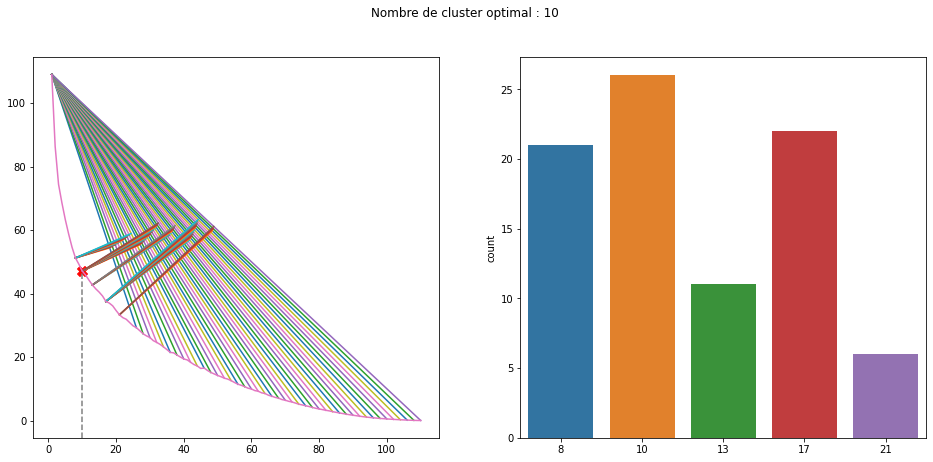

In [59]:
k_calc, results = f_clusters_coude(data, k_fine=15, k_seuil= 25, k_end=110, n_init=200)


In [53]:
k_calc

9

## Création des clusters

In [ ]:
# Choix du nombre de clusters à créer
nbre_clusters = 8

In [ ]:
# Entrainement
cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters, n_init = 2000, max_iter = 500)

# répartition des piezos dans les clusters
sns.countplot(data = cluster_table, x = "cluster")

In [ ]:
cluster_centers.head()

In [ ]:
cluster_table.head()

## Affichage des clusters

In [ ]:
f_plot_clusters(data, cluster_table, cluster_centers)
#cluster_table.groupby("cluster").mean()

In [ ]:
#f_plot_all(data, cluster_table, cluster_centers)

## Filtre des chroniques avec score insuffisant

In [ ]:
plt.figure(figsize=(8, 6))
ax = cluster_table["MSE"].sort_values().plot(title = "MSE chronique / centroïde")
ax.set_xlabel("")
ax.set_ylabel("MSE")
ax.tick_params(left = True, right = False , labelleft = True ,
                labelbottom = False, bottom = False)
plt.show()


In [ ]:
# nbre de chroniques sous le seuil
MSEmax = f_MSEmax(cluster_table)
cluster_table.loc[cluster_table.MSE > MSEmax, "cluster"] = 0

nbre_elim_total = 0
nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmax, 'MSE'].count()
nbre_elim_total += nbre_elim

iteration = 1
print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")

data_opt = data.copy()

while nbre_elim != 0 :
    
    # Selection des clusters non zéro
    data_opt = data.copy().loc[:,cluster_table.loc[cluster_table.cluster != 0].index]
    
    # Nouveau clustering
    cluster_table, cluster_centers = f_clusters_fit(data_opt, nbre_clusters, n_init = 2000, max_iter = 500)

    # chroniques sous le seuil passées à cluster 0
    MSEmax = f_MSEmax(cluster_table)
    nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmax, 'MSE'].count()   
    nbre_elim_total += nbre_elim
    

    cluster_table.loc[cluster_table.MSE > MSEmax, "cluster"] = 0
    iteration += 1
    print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")

    
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{index+1}"}, inplace=True)    
    
print(f"Nombre total de chroniques éliminées : {nbre_elim_total}")

plt.figure(figsize=(8, 6))
ax = cluster_table["MSE"].sort_values().plot(title = "MSE chronique / centroïde")
ax.set_xlabel("")
ax.set_ylabel("MSE")
ax.tick_params(left = True, right = False , labelleft = True ,
                labelbottom = False, bottom = False)
plt.show()


In [ ]:
f_plot_clusters(data_opt, cluster_table, cluster_centers)

In [ ]:
sns.countplot(data = cluster_table, x = "cluster")

## Sous-clusters - linkage / dendogramme

In [ ]:
Z = hierarchy.linkage(cluster_centers.T, method='ward', optimal_ordering=True)
plt.figure()
dn = hierarchy.dendrogram(Z, 
                          labels=list(cluster_centers.columns),
                          count_sort = 'descending',
                          distance_sort = 'ascending',
                          get_leaves =True,
                          show_leaf_counts = True,
                          color_threshold = max(Z[:,2])/2)

cluster_order = dn.get('ivl')
codes_couleur = dn.get('leaves_color_list')


In [ ]:
# Décompte du nombre d'une même couleur présente consécutivement
compteur = [1]
index_compteur = 0
for index in range (1,len(codes_couleur)) :
    if codes_couleur[index] == codes_couleur[index-1] :
        compteur[index_compteur] += 1
    else :
        index_compteur += 1
        compteur.append(1)
        
ch = "A"
new_codes_couleur = []

for index, number in enumerate (compteur) :
    if number == 1 :
        new_codes_couleur.append(ch)
    else :
        for num_sc in range (1,number+1):
            new_codes_couleur.append(ch + str(num_sc))
    ch = chr(ord(ch)+1)
new_codes_couleur

### Modification des libellés

In [ ]:
# Conversion nom numérique en nom littéral

# - Cluster table
cluster_table.replace(list(map(int, cluster_order)), new_codes_couleur, inplace=True)

# - Cluster centers
dict_rename = dict(zip(cluster_order, new_codes_couleur))
cluster_centers.rename(columns=dict_rename, inplace=True)

In [ ]:
cluster_table.head()

In [ ]:
cluster_centers.head()

# Enregistrement des profils des clusters

In [ ]:
cluster_centers.to_csv(f"./data/{region}_clusters.csv")

# Ajout à la bdd

In [ ]:
# Nom de la table
table = "cluster_kmeans"

In [ ]:
# Création de la table
requete = f"""
                    ALTER TABLE data_piezo
                    ADD {table} VARCHAR(6) DEFAULT NULL
                    """
f_requete_sql(requete)

In [ ]:
# Création de listes de nuéro de cluster avec le nom des piezos
# Ajout dans la bdd
for label in set(cluster_table.cluster):
    cluster = tuple(cluster_table.loc[cluster_table.cluster == label, 'cluster'].index.to_list())
    requete = f"""
        UPDATE data_piezo
        SET {table} = '{region}_{label}'
        WHERE code_bss IN {cluster}
        """
    f_requete_sql(requete)

## Suppresion colonne

requete = """
                    ALTER TABLE data_piezo
                    DROP cluster_kmeans
                    """
f_requete_sql(requete)

# Chronique caractéristique des clusters

In [ ]:
# Recherche du code_bss avec la valeur MSE la plus faible
liste_top_bss = []
for cluster in cluster_table.cluster.unique() :
    liste_top_bss.append(cluster_table.loc[cluster_table.cluster == cluster].sort_values("MSE").index[0])
df_top = pd.DataFrame(liste_top_bss, cluster_table.cluster.unique(), columns=["code_bss"])

df_top = df_top.sort_index()

In [ ]:
fig, axs = plt.subplots(len(df_top),1,figsize=(10,40))
for i in range (len(df_top)):
    cluster = df_top.index[i]
    bss = df_top.code_bss[i]
    axs[i].plot(cluster_centers.loc[:,cluster], 'red')
    axs[i].plot(data_opt.loc[:,bss])
    axs[i].set_title("Cluster "+ cluster + " - " + bss)    
                

## Ajout à la bdd

In [ ]:
code_cluster = tuple(region + "_" +  df_top.index)
code_bss = tuple(df_top.index)
tableau = list(np.stack((code_cluster,code_bss), axis=1))
for index, line in enumerate(tableau):
    tableau[index] = tuple(line)

In [ ]:
# Création de la table
requete = f"""
            CREATE TABLE IF NOT EXISTS flagship_piezo (
            code_cluster VARCHAR(8) PRIMARY KEY ON CONFLICT IGNORE,
            code_bss VARCHAR(8)
            )
            """
f_requete_sql(requete)

In [ ]:
requete = f"INSERT INTO flagship_piezo (code_cluster, code_bss) VALUES (?,?)"

try:
    connexion = sqlite3.connect('../data/liste_piezos.db')
    curseur = connexion.cursor()
    print("Connexion réussie à SQLite")
    curseur.executemany(requete, tableau)
    connexion.commit()
    resultat = curseur.fetchall()
    curseur.close()
    connexion.close()
    print("Connexion SQLite est fermée")
except sqlite3.Error as error:
    print("Erreur lors du mis à jour dans la table : ", error)

### Suppression données region

In [ ]:
# Création de la table
requete = f"""
            DELETE FROM flagship_piezo
            WHERE code_cluster LIKE '{region}%'
            """
f_requete_sql(requete)